In [1]:
# Imports
import gzip
import os
from helper import *
import pandas as pd
import numpy as np
# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import nltk
from nltk.probability import FreqDist
import itertools
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

Vocabulary constructed


# Data Screening

## label2answer 

First we will start by investigating similar files that only differs in their names by 'raw' or 'token' in order to see the difference. We will first start by label2answer files.

In [2]:
# Read label2answer files, raw and token
raw_label2answer = read_data(PATH + 'InsuranceQA.label2answer.raw.encoded.gz', "label2answer")
token_label2answer = read_data(PATH + 'InsuranceQA.label2answer.token.encoded.gz', "label2answer")

Reading label2answer data. 
This data format is: <Answer Label><TAB><Answer Text> 

Reading label2answer data. 
This data format is: <Answer Label><TAB><Answer Text> 



These files contains two columns Answer labels and the answer text i.e. every answer is assigned to a number.<br>
Answers here are a list of indexes, each one of them is a key in the vocabulary dictionary. In the helper.py we defined functions that help us manipulate the indexes and map them to words.

In [3]:
# Select an example from the raw_label2answer data
' '.join(convert_from_idx_str(raw_label2answer[100][1]))

'If the primary beneficiary dies before the policy owner dies, the contingent beneficiary would be the next in line for benefits. If the policy owner is well, he or she would simply call the insurance company and request a "change of beneficiary" form and rename a new primary beneficiary. If it is the contingent who becomes primary then the owner would rename a new contingent beneficiary.'

In [4]:
# Select an example from the token_label2answer data
' '.join(convert_from_idx_str(token_label2answer[100][1]))

"If the primary beneficiary dies before the policy owner dies , the contingent beneficiary would be the next in line for benefits . If the policy owner is well , he or she would simply call the insurance company and request a `` change of beneficiary '' form and rename a new primary beneficiary . If it is the contingent who becomes primary then the owner would rename a new contingent beneficiary ."

As you can see from above the 'raw' contains the data as it's entered by the users! The 'token' one is the data processed(cleaned, word separated from punctuation) ready for vectorization i.e. ready for embedding. 

For visualisation and better manipulation of the data we will use pandas dataframes for our analysis. 

In [5]:
# dataFrame that contains the answer_labes and the answer_text 
# We will consider the data in the 'token' files
l2a = pd.DataFrame(read_data(PATH + 'InsuranceQA.label2answer.token.encoded.gz', "label2answer"), 
                                                       columns = ['answer_label', 'answer_idx'])
# to have every thing in the same dataFrame we will append the answer text to the dataframe 
l2a['answer_text'] = l2a['answer_idx'].apply(lambda a: convert_from_idx_str(a))

l2a.head()

Reading label2answer data. 
This data format is: <Answer Label><TAB><Answer Text> 



answer_label                                         answer_idx  \
0             1  [idx_1, idx_2, idx_3, idx_12, idx_1305, idx_5,...   
1             2  [idx_124, idx_107, idx_11, idx_125, idx_757, i...   
2             3  [idx_7, idx_8, idx_77, idx_292, idx_97, idx_66...   
3             4  [idx_315, idx_3, idx_294, idx_20, idx_316, idx...   
4             5  [idx_76, idx_341, idx_41, idx_11, idx_342, idx...   

                                         answer_text  
0  [Coverage, follows, the, car, ., Example, 1, :...  
1  [That, is, a, great, question, !, One, I, 'm, ...  
2  [If, you, are, applying, for, Medicaid, ,, lif...  
3  [Calling, the, life, insurance, company, throu...  
4  [The, cost, of, a, Medigap, plan, is, differen...

In the helper.py file we defined a function that convert a list of indexes to the sentence associated to it (from vocabulary dictionary).

**Stats and visualization**

In [6]:
print("The number of answers is ", len(l2a))

The number of answers is  27413


In [7]:
# Adding the length of the questions
l2a['answer_length'] = l2a['answer_text'].apply(lambda q: len(q))
l2a.head()

answer_label                                         answer_idx  \
0             1  [idx_1, idx_2, idx_3, idx_12, idx_1305, idx_5,...   
1             2  [idx_124, idx_107, idx_11, idx_125, idx_757, i...   
2             3  [idx_7, idx_8, idx_77, idx_292, idx_97, idx_66...   
3             4  [idx_315, idx_3, idx_294, idx_20, idx_316, idx...   
4             5  [idx_76, idx_341, idx_41, idx_11, idx_342, idx...   

                                         answer_text  answer_length  
0  [Coverage, follows, the, car, ., Example, 1, :...            235  
1  [That, is, a, great, question, !, One, I, 'm, ...            424  
2  [If, you, are, applying, for, Medicaid, ,, lif...             71  
3  [Calling, the, life, insurance, company, throu...             66  
4  [The, cost, of, a, Medigap, plan, is, differen...            215

In [8]:
# Description of the answers_length attribute
l2a[['answer_length']].describe()

answer_length
count   27413.000000
mean      111.826214
std        77.166811
min        16.000000
25%        67.000000
50%        87.000000
75%       125.000000
max      1335.000000

The mean of the answers length is 111.8 word! and the mean is 16, this means that the size of the answers we have is quite long. Let's investigate more it's distribution. 

In [9]:
# The distribution of the length of answers
l2a['answer_length'].iplot(kind='scatter', xTitle = 'answer', yTitle = 'length'
                                         , title='Answers length scatter plot')

From the scatter plot above it seems to be that the length of the answer is quite high. This may be due to the nature of our dataset, the answers about insurance need to be precise and well formulated in order to explain better to clients. This also can be due to the fact that collaborators are using a lot of formal expressions since they are talking to clients.

In [10]:
# The distribution of the length of answers 
l2a['answer_length'].iplot(kind='hist', xTitle='length',histnorm = 'density', 
                         yTitle='count', title='Answers length Distribution',linecolor = 'black')

The distribution is skewed to the right! This means that the mean length is bigger than the median length. Besides, the data points on the right side of the distribution are 'invisible' which tells us that they can be outliers! Let's use a box plot to see the 'suspectedoutliers' points.

In [11]:
# Box plot of the length of answres with suspectedoutliers as argument
l2a[['answer_length']].iplot(kind='box', mode='lines', boxpoints = 'suspectedoutliers')

Here from the size of the box plot we can see that we have outliers! So let's have a closer look.

In [12]:
# let's look at the questions with lenght > 1000
list(l2a[l2a['answer_length'] > 1000]['answer_text'].apply(lambda q: ' '.join(q)))[0]

'Gap insurance is a coverage that is offered either on your auto policy or through the auto finance company as an option -LRB- or requirement -RRB- on your loan . Basically , what it does is provide you a clean slate if you total a car with a loan on it . Lets look at an example : Erica buys a 2009 Volkswagon Jetta from a used car shop for $ 14,000 . The used car value could be 12,500 depending on what form you use -LRB- blackbook value , NADA , Kelly Bluebook value , etc. -RRB- The form doesnt matter here other than answering the question of is this car worth less than the loan I have on it ? Erica is required to have other-than-collision coverage -LRB- often called comprehensive coverage , which is a misnomer -RRB- and collision coverage as a stipulation for the loan she is getting with the bank or finance company . That coverage states that it will repair her car for specific reasons in the policy OR pay her the actual cash value of the car if it costs less than the repairs it would

As you can see from the example above, the insurance responses seems to be so technical sometimes so in order to make sure that the information is well transmitted to clients, collaborators uses examples and create scenarios. 

In [13]:
# Let's take an answer with small length
list(l2a[l2a['answer_length'] < 40]['answer_text'].apply(lambda q: ' '.join(q)))[0]

'Disability Insurance is paycheck protection . When you insure yourself against sickness or injury , youre valuing your ability to earn money for your family and/or business partners , who can benefit if youre unable to work .'

Other questions are straight forward so the answer is relatively short! 
<br>
However, the answer is always related to the question! So if the answer is too long it's because the question covered an important number of subjects. So let's look at the questions data.

## label2question

In [14]:
# Reading the questions files, raw and token 
raw_label2question = read_data(PATH + 'InsuranceQA.question.anslabel.raw.encoded.gz',"question.anslabel")
token_label2question = read_data(PATH + 'InsuranceQA.question.anslabel.token.encoded.gz',"question.anslabel")

Reading questions.anslabel data.
This data foramt is: <Domain><TAB><QUESTION><TAB><Groundtruth>

Reading questions.anslabel data.
This data foramt is: <Domain><TAB><QUESTION><TAB><Groundtruth>



In [15]:
raw_label2question[0]

['medicare-insurance',
 ['idx_1285', 'idx_1010', 'idx_467', 'idx_47610', 'idx_18488', 'idx_65760'],
 ['16696']]

Here the lable2question data contains in the first the position the domain of the asked question, followed by a list of indexes (again keys of words in vocabulary dictionary) and a list of ground truths which they are labels for answers. This means that a questions can have multiple answers. 

In [16]:
' '.join(convert_from_idx_str(raw_label2question[0][1]))

'What Does Medicare IME Stand For?'

In [17]:
' '.join(convert_from_idx_str(token_label2question[0][1]))

'What Does Medicare IME Stand For ?'

The same thing goes for label2question files, the 'raw' files are the questions as entered by clients and the 'token' are the one processed for machine learning purposes.

In [18]:
# Construct dataFrame for raw_label2question
l2q = pd.DataFrame(read_data(PATH + 'InsuranceQA.question.anslabel.token.encoded.gz',"question.anslabel"), 
                                               columns = ['domain', 'questions_idx', 'groundTruth_labels'])
l2q.head()

Reading questions.anslabel data.
This data foramt is: <Domain><TAB><QUESTION><TAB><Groundtruth>



domain  \
0        medicare-insurance   
1  long-term-care-insurance   
2          health-insurance   
3        medicare-insurance   
4        medicare-insurance   

                                       questions_idx groundTruth_labels  
0  [idx_1285, idx_1010, idx_467, idx_47610, idx_1...            [16696]  
1  [idx_3815, idx_604, idx_605, idx_891, idx_136,...            [10277]  
2  [idx_3019, idx_55039, idx_27647, idx_60975, id...            [12076]  
3  [idx_3815, idx_467, idx_34801, idx_1655, idx_7...      [25578, 6215]  
4  [idx_1010, idx_467, idx_21593, idx_64564, idx_...            [22643]

To have a better visualization of the data we will append the plain text associated to indexes.

In [19]:
# Add the questions plain text 
l2q['questions_text'] = l2q['questions_idx'].apply(lambda q: ' '.join(convert_from_idx_str(q)))
l2q.head()

domain  \
0        medicare-insurance   
1  long-term-care-insurance   
2          health-insurance   
3        medicare-insurance   
4        medicare-insurance   

                                       questions_idx groundTruth_labels  \
0  [idx_1285, idx_1010, idx_467, idx_47610, idx_1...            [16696]   
1  [idx_3815, idx_604, idx_605, idx_891, idx_136,...            [10277]   
2  [idx_3019, idx_55039, idx_27647, idx_60975, id...            [12076]   
3  [idx_3815, idx_467, idx_34801, idx_1655, idx_7...      [25578, 6215]   
4  [idx_1010, idx_467, idx_21593, idx_64564, idx_...            [22643]   

                                  questions_text  
0             What Does Medicare IME Stand For ?  
1         Is Long Term Care Insurance Tax Free ?  
2  Can Husband Drop Wife From Health Insurance ?  
3            Is Medicare Run By The Government ?  
4                  Does Medicare Cover Co-Pays ?

Next, we will handle groundTruth_labels with multiple values. We will explode those rows and we will duplicate the values of the remaining ones. 

In [20]:
def split_data_frame_list(df, target_column):
    """
    Splits a column with lists into rows
    
    arguments:
    df--dataframe
    target_column --name of column that contains lists        
    """
    # create a new dataframe with each item in a seperate column, dropping rows with missing values
    col_df = pd.DataFrame(df[target_column].dropna().tolist(),index=df[target_column].dropna().index)
    # create a series with columns stacked as rows         
    stacked = col_df.stack()
    return pd.DataFrame(stacked, columns=[target_column])

In [21]:
# Explode the raws that contain more than one element in the groundTruth_labels list
df_groundTruth = split_data_frame_list(l2q, 'groundTruth_labels').reset_index().drop('level_1', axis = 1)
df_groundTruth.head()

level_0 groundTruth_labels
0        0              16696
1        1              10277
2        2              12076
3        3              25578
4        3               6215

In [22]:
# Merge the df_groundTruth withe l2q dataframe
l2q = df_groundTruth.merge(l2q, left_on = 'level_0', right_index = True).drop(['level_0'], axis = 1)
l2q.head()

groundTruth_labels_x                    domain  \
0                16696        medicare-insurance   
1                10277  long-term-care-insurance   
2                12076          health-insurance   
3                25578        medicare-insurance   
4                 6215        medicare-insurance   

                                       questions_idx groundTruth_labels_y  \
0  [idx_1285, idx_1010, idx_467, idx_47610, idx_1...              [16696]   
1  [idx_3815, idx_604, idx_605, idx_891, idx_136,...              [10277]   
2  [idx_3019, idx_55039, idx_27647, idx_60975, id...              [12076]   
3  [idx_3815, idx_467, idx_34801, idx_1655, idx_7...        [25578, 6215]   
4  [idx_3815, idx_467, idx_34801, idx_1655, idx_7...        [25578, 6215]   

                                  questions_text  
0             What Does Medicare IME Stand For ?  
1         Is Long Term Care Insurance Tax Free ?  
2  Can Husband Drop Wife From Health Insurance ?  
3            Is Medicare Run By The Government ?  
4            Is Medicare Run By The Government ?

Now every all possible answer to a question are considered as different question answer tuple.

In [23]:
# Add the question plain text to the dataframe
l2q['groundTruth_text'] = l2q['groundTruth_labels_x'].apply(lambda t:
                                ' '.join(convert_from_idx_str(token_label2answer[int(t)-1][1])))
# Reorder the columns for better visualization
l2q = l2q[['domain', 'questions_idx', 'groundTruth_labels_y', 'groundTruth_labels_x', 
                                               'questions_text', 'groundTruth_text']]
l2q.head()

domain  \
0        medicare-insurance   
1  long-term-care-insurance   
2          health-insurance   
3        medicare-insurance   
4        medicare-insurance   

                                       questions_idx groundTruth_labels_y  \
0  [idx_1285, idx_1010, idx_467, idx_47610, idx_1...              [16696]   
1  [idx_3815, idx_604, idx_605, idx_891, idx_136,...              [10277]   
2  [idx_3019, idx_55039, idx_27647, idx_60975, id...              [12076]   
3  [idx_3815, idx_467, idx_34801, idx_1655, idx_7...        [25578, 6215]   
4  [idx_3815, idx_467, idx_34801, idx_1655, idx_7...        [25578, 6215]   

  groundTruth_labels_x                                 questions_text  \
0                16696             What Does Medicare IME Stand For ?   
1                10277         Is Long Term Care Insurance Tax Free ?   
2                12076  Can Husband Drop Wife From Health Insurance ?   
3                25578            Is Medicare Run By The Government ?   
4                 6215            Is Medicare Run By The Government ?   

                                    groundTruth_text  
0  According to the Centers for Medicare and Medi...  
1  As a rule , if you buy a tax qualified long te...  
2  Can a spouse drop another spouse from health i...  
3  Medicare Part A and Part B is provided by the ...  
4  Definitely . It is ran by the Center for Medic...

**Stats and visualization**

In [24]:
print("Number of questions is", len(l2q.groupby('questions_text').count()))

Number of questions is 16889


In [25]:
print("Number of answers used is", len(l2q))

Number of answers used is 27987


The number of answer from the label2answer is 27413 and the number of answers in label2question is 27987. This means that some answers are used multiple times, they answer multiple questions at the same time. Let's see an example of these answers.

In [26]:
# Since our dataframe contains tuples of questions and answer we need to groupby the groundTruth to find
# duplicated answers
duplicated_answers = l2q.groupby('groundTruth_text').count()[['domain']].rename(columns = {'domain': 'count'})
# Keep only duplicated raws
duplicated_answers = duplicated_answers[duplicated_answers['count']>1]

In [27]:
print("The number of duplicated answers is", len(duplicated_answers))

The number of duplicated answers is 520


In [28]:
# The distribution of the length of answers 
duplicated_answers['count'].iplot(kind='hist', xTitle='number of duplications', 
                         yTitle='count', title='distribution of duplication',linecolor = 'black')

The number of answers duplicated twice represents the majority by 485 from 520. However, there is 15 answer duplicated more than 4 times! Let's look at an example.

In [29]:
# Select rows duplicated more than 4 times
duplicated_answers = duplicated_answers[duplicated_answers['count'] > 4]
duplicated_answers.head()

count
groundTruth_text                                         
Disability insurance depends on a number of fac...      6
Group health insurance quotes are based on the ...      5
It varies from person to person . Your age , wh...      6
You can apply for a Medigap plan up to 3 months...      6

Let's investigate questions associated to these answers

In [30]:
duplicated_answers.merge(l2q, left_index = True, right_on = 'groundTruth_text')[['domain', 'questions_text',
                                                                                'groundTruth_text']]

domain  \
1154   disability-insurance   
1783   disability-insurance   
4566   disability-insurance   
11187  disability-insurance   
15063  disability-insurance   
20094  disability-insurance   
4676       health-insurance   
4732       health-insurance   
5579       health-insurance   
10906      health-insurance   
13774      health-insurance   
1298       health-insurance   
4146       health-insurance   
9220       health-insurance   
13093      health-insurance   
15752      health-insurance   
27568      health-insurance   
6554     medicare-insurance   
10128    medicare-insurance   
12003    medicare-insurance   
15150    medicare-insurance   
22258    medicare-insurance   
24612    medicare-insurance   

                                          questions_text  \
1154   How Much Does Long Term Disability Insurance C...   
1783    How Much Does Disability Income Insurance Cost ?   
4566     What Does Long Term Disability Insurance Cost ?   
11187  How Much Does Disability Insurance Cost Per Mo...   
15063         How Much Could Disability Insurance Cost ?   
20094     How Much Do You Pay For Disability Insurance ?   
4676   How Much Is Health Insurance For A Small Busin...   
4732   How Much Does Group Health Insurance Cost A Sm...   
5579    Much Does Health Insurance Cost Small Business ?   
10906  How Much Does Health Insurance Cost For Small ...   
13774  How Much Does A Small Business Pay For Health ...   
1298            How Much Is It To Get Health Insurance ?   
4146        How Much Does A Good Health Insurance Cost ?   
9220   How Much Is Individual Health Insurance In New...   
13093  How Much Does Health Insurance For One Person ...   
15752  How Much Does Health Insurance Cost Per Month ...   
27568    How Much Does Health Insurance Cost At Age 62 ?   
6554                     When Can I Get A Medigap Plan ?   
10128                 When Can You Sign Up For Medigap ?   
12003              When Can I Enroll In A Medigap Plan ?   
15150     When Is Open Enrollment For Medigap Policies ?   
22258                   When Can I Sign Up For Medigap ?   
24612               When To Sign Up For Medigap Policy ?   

                                        groundTruth_text  
1154   Disability insurance depends on a number of fa...  
1783   Disability insurance depends on a number of fa...  
4566   Disability insurance depends on a number of fa...  
11187  Disability insurance depends on a number of fa...  
15063  Disability insurance depends on a number of fa...  
20094  Disability insurance depends on a number of fa...  
4676   Group health insurance quotes are based on the...  
4732   Group health insurance quotes are based on the...  
5579   Group health insurance quotes are based on the...  
10906  Group health insurance quotes are based on the...  
13774  Group health insurance quotes are based on the...  
1298   It varies from person to person . Your age , w...  
4146   It varies from person to person . Your age , w...  
9220   It varies from person to person . Your age , w...  
13093  It varies from person to person . Your age , w...  
15752  It varies from person to person . Your age , w...  
27568  It varies from person to person . Your age , w...  
6554   You can apply for a Medigap plan up to 3 month...  
10128  You can apply for a Medigap plan up to 3 month...  
12003  You can apply for a Medigap plan up to 3 month...  
15150  You can apply for a Medigap plan up to 3 month...  
22258  You can apply for a Medigap plan up to 3 month...  
24612  You can apply for a Medigap plan up to 3 month...

As you can see above the questions are 'similar' so the answer duplication is a 'normal' behavior . <br>
How Much Is It To Get Health Insurance ? <u> is the same as </u> 'How Much Does A Good Health Insurance Cost ? <br>
so 

Our data contains the domain field, so let's see the number of domains covered.

In [31]:
# Construct the domain dataFrame
domains = l2q.groupby('domain').count()[['questions_idx']].rename(columns = {'questions_idx': 'count'})
# sort count values
domains = domains.sort_values('count', ascending = False).reset_index()
domains

domain  count
0               life-insurance  10206
1               auto-insurance   3333
2           medicare-insurance   2948
3             health-insurance   2669
4               home-insurance   2507
5         disability-insurance   1540
6            renters-insurance   1489
7                    annuities   1185
8             retirement-plans    961
9     long-term-care-insurance    780
10  critical-illness-insurance    262
11             other-insurance    107

In [32]:
print("the number of domains is", len(domains))

the number of domains is 12


In [33]:
# Pie chart of the number of domains
domains.iplot(kind='pie',labels='domain',values='count',pull=.2,hole=.2,
          colorscale='blues',textposition='outside',textinfo='value+percent')

As you can observe from the pie chart the life insurance domains is the most important. It represents 36.5% of the data. Critical-illness-insurance and other-insurance represents together only 1.3 % of the data which is very small compared to the remaining domains.

Next I will see the distribution of the questions length as we did for answers length. 

In [34]:
# Groupby questions in order to eleminate duplicated question and keep only questions
questions = l2q.groupby('questions_text').count().reset_index()[['questions_text']]
# Add the length of the questions feature
questions['questions_length'] = questions['questions_text'].apply(lambda q: len(q))
questions.head()

questions_text  questions_length
0  A Lot Of Doctors Say Medicare Is Better And Hu...                98
1  A Whole Life Policy Owner Passed Away With Cas...               135
2  A am a 20 year old single male wondering how m...               125
3          About How Much Does Auto Insurance Cost ?                41
4  About How Much Does Car Insurance Cost For A 1...                58

In [35]:
# The distribution of the length of questions 
questions['questions_length'].iplot(kind = 'scatter', xTitle = 'question', yTitle = 'length',
                                     mode = 'markers' , title='Questions length scatter plot')

The length of the questions is smaller than the length of answer. This is kind of normal since collaborators develop answers to make it clear for the client.  

In [36]:
# The distribution of the length of questions 
questions['questions_length'].iplot(kind='hist', xTitle='length',histnorm = 'density', 
                         yTitle='count', title='Questions length Distribution',linecolor = 'black')

The distribution of the answers is similar to the questions distribution! Which is something we expected, long questions demand detailed answer. 

##  anslabel

In [37]:
raw_anslabel = read_data(PATH + 'InsuranceQA.question.anslabel.raw.100.pool.solr.test.encoded.gz', "anslabel")
token_anslabel = read_data(PATH + 'InsuranceQA.question.anslabel.token.100.pool.solr.test.encoded.gz', "anslabel")

Reading Train/Test/Validation file.
This data format is: <Domain><TAB><QUESTION><TAB><Groundtruth><TAB><Pool>

Reading Train/Test/Validation file.
This data format is: <Domain><TAB><QUESTION><TAB><Groundtruth><TAB><Pool>



These files are composed from domain, question followed by groundtruth selected from a answers in the pool. The pool size is the defined by the number of possible answers. In our case we selected pool size equal to 100. <br>
At this level the questions and the answers are indexes(keys in vocabulary dictionary) and labels(index in label2answer). Pool includes ground_truth and also randomly selected negative answers.

In [38]:
# Read the file in a dataframe
raw_al = pd.DataFrame(token_anslabel, columns = ['domain', 'Questions', 'groundTruth', 'pool'])

raw_al.head()

domain  \
0            life-insurance   
1         renters-insurance   
2            home-insurance   
3  long-term-care-insurance   
4        medicare-insurance   

                                           Questions         groundTruth  \
0  [idx_1285, idx_65774, idx_862, idx_605, idx_44...  [16164, 99, 26337]   
1  [idx_1285, idx_1010, idx_999, idx_136, idx_215...       [22542, 4380]   
2  [idx_1010, idx_17002, idx_382, idx_65840, idx_...             [26439]   
3  [idx_1285, idx_239, idx_49, idx_739, idx_31, i...              [6996]   
4  [idx_2363, idx_467, idx_8080, idx_31, idx_9966...              [9128]   

                                                pool  
0  [15813, 3286, 22367, 21353, 4977, 6406, 24335,...  
1  [2235, 26739, 24916, 17855, 3406, 21201, 70, 1...  
2  [23486, 2424, 14974, 3344, 7712, 6220, 5346, 1...  
3  [17044, 11643, 1904, 25722, 17842, 12460, 2036...  
4  [9128, 13322, 21601, 21471, 6442, 5412, 24861,...

This data is for training models, it's the same as the one constructed in label2quetion part so no further analysis are carried.

# NLTK Analysis

## label2answer

In [39]:
def fdist(words):
    '''
    This function creates the frequnce distance 
    
    arguments:
    words--list of sentences
    '''
    # Construct the frequency distance matrix
    return FreqDist(words)

In [40]:
# Construct the frequence distance
fdist_answer = fdist(list(itertools.chain(*l2a['answer_text'])))
# top 10 most common words
fdist_answer.most_common(10)

[('.', 139684),
 ('the', 118953),
 (',', 98192),
 ('to', 80357),
 ('a', 73161),
 ('you', 69899),
 ('of', 56556),
 ('is', 53402),
 ('and', 52711),
 ('insurance', 42609)]

'insurance' appears at the 10th position, this is a very high position because it's ranked with the stopwords.

In [41]:
# Plot the curve of words frequency
def freq_plot(freq, samples):
    '''
    This function take the frequency distance matrix
    and plots the most common number of samples
    
    arguments: 
    freq--the frequency matrix
    samples--number of sample to plot
    '''
    plt.figure(figsize=(15,6))
    plt.title('Word frequency')
    plt.xlabel('word')
    freq.plot(samples, cumulative = False)
    plt.show()

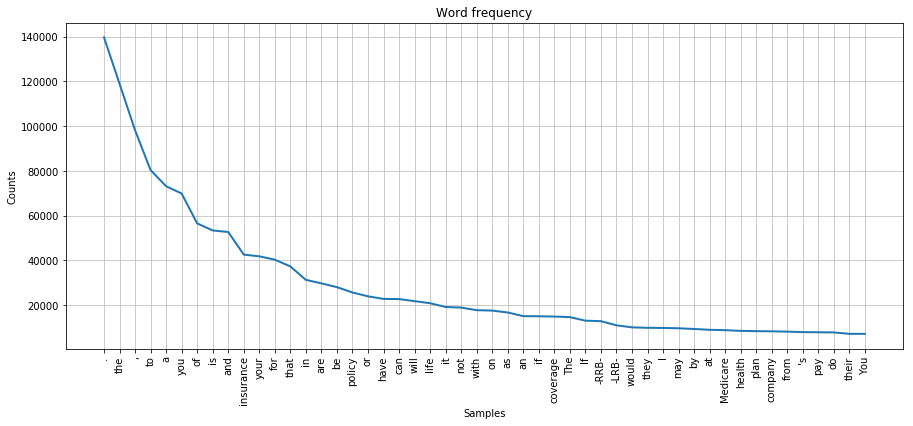

In [42]:
freq_plot(fdist_answer, 50)

The curve of the words frequency decreases exponentially.

Stopwords considered as noise in the text. Text may contain stop words such as is, am, are, this, a, an, the, etc. So let's remove them.

In [43]:
# Download stop words
stop_words = set(stopwords.words("english"))
# Define a function to remove stopwords
def remove_stopwords(tokenized_sent, stop_words):
    '''
    This function removes stopwords from sentences
    
    arguments: 
    tokenized_sent--list of tokenized words
    stop_words--list of stopwrods (here downloaded from nltk)
    '''
    filtered_sent = []
    for w in list(itertools.chain(*tokenized_sent)):
        if w not in stop_words:
            filtered_sent.append(w)
    return filtered_sent

In [44]:
# Create a filtred list of answers words (no stopwords)
filtered_sent_answer = remove_stopwords(list(l2a['answer_text']), list(stop_words))

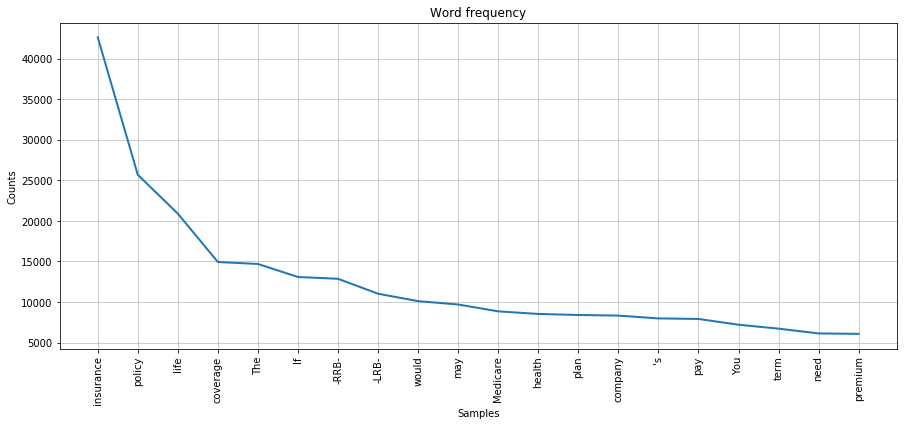

In [45]:
# Plot the most common words (We selected words with than 1 char to avoid punctuation)
freq_plot(fdist([l for l in filtered_sent_answer if len(l)>1]),20)

Stemming is a process of linguistic normalization, which reduces words to their word root word or chops off the derivational affixes. For example, connection, connected, connecting word reduce to a common word "connect".<br>
This may helps us understand better the words used in our insurance data.

In [46]:
# Create the stemmer
ps = PorterStemmer()

def stemm(filtered_sent):
    '''
    This function transform the words to their word root
    
    arguments:
    filtred_sent--a list of words (in our case it's without stopwords)
    '''
    stemmed_words=[]
    for w in filtered_sent:
        stemmed_words.append(ps.stem(w))
    return stemmed_words

In [47]:
# Create the stemmed list of words
stemmed_words_answer = stemm(filtered_sent_answer)

## label2question

In [48]:
# Construct the frequence distance from a list of words
fdist_question = fdist(list(itertools.chain(*l2q['questions_text'].apply(lambda q: q.split(' ')))))
# top 10 most common words
fdist_question.most_common(10)

[('?', 27955),
 ('Insurance', 22794),
 ('Life', 10164),
 ('Is', 7549),
 ('Does', 7119),
 ('What', 6334),
 ('A', 5805),
 ('How', 5691),
 ('Can', 4772),
 ('I', 4414)]

Again the insurance words is in a good position but it's too much lower than in the answers case! However we can notice that the question terms are the most common.

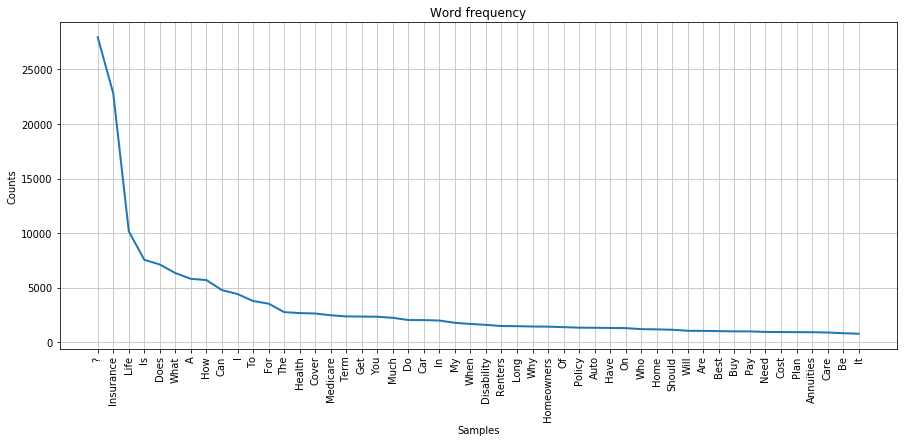

In [49]:
freq_plot(fdist_question, 50)

In [50]:
# Create a filtred list of answers words (no stopwords)
filtered_sent_questions = remove_stopwords(list(l2q['questions_text'].apply(lambda q: q.split(' '))), list(stop_words))

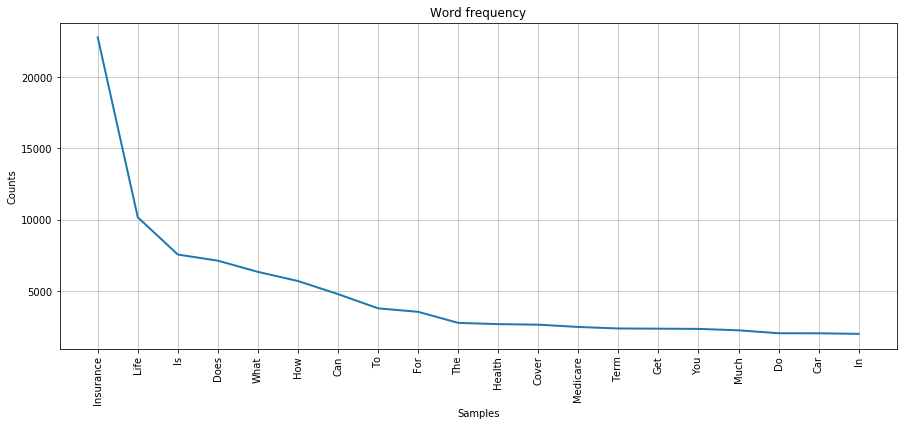

In [51]:
# Plot the most common words (We selected words with than 1 char to avoid punctuation)
freq_plot(fdist([l for l in filtered_sent_questions if len(l)>1]),20)

## POS Tagging

In [52]:
# Answer words
answer_words = list(itertools.chain(*l2a['answer_text']))
# Question words
question_words = list(itertools.chain(*l2q['questions_text'].apply(lambda q: q.split(' '))))

In [53]:
# Construct answer pos tags
answer_pos_tag = nltk.pos_tag(answer_words, tagset = 'universal')
# Construct question pos tags
question_pos_tag = nltk.pos_tag(question_words, tagset = 'universal')

In [54]:
# Construct dataframe from tags
answer_pos_tag = pd.DataFrame(answer_pos_tag, columns = ['words', 'tag'])
question_pos_tag = pd.DataFrame(question_pos_tag, columns = ['words', 'tag'])

In [55]:
# pie chart of the distirbution of tags
answer_pos_tag.groupby('tag').count().sort_values('words', ascending = False).reset_index().\
iplot(kind='pie',labels='tag',values='words',pull=.1,hole=.2,
          colorscale='blues',textposition='outside',textinfo='value+percent')

In [56]:
question_pos_tag.groupby('tag').count().sort_values('words', ascending = False).reset_index().\
iplot(kind='pie',labels='tag',values='words',pull=.2,hole=.2,
          colorscale='reds',textposition='outside',textinfo='value+percent')

For both questions and answers noun and verb are the most frequent tags. However, for questions it represents 51% of the words. 

# Semantic Analytics

## polarity analyis

In [84]:
from textblob import TextBlob, Word, Blobber
# Add polarity to label2question
l2q['polarity'] = l2q['questions_text'].map(lambda text: TextBlob(text).sentiment.polarity)
# Add polarity to label2answer 
l2a['polarity'] = l2a['answer_text'].apply(lambda a: ' '.join(a)).\
                            map(lambda text: TextBlob(text).sentiment.polarity)

In [79]:
l2q['polarity'].iplot(kind = 'hist', bins = 50, xTitle = 'polarity',linecolor = 'black', yTitle = 'count', 
                      title = 'Sentiment Polarity Distribution')

For the questions the polarity is concentrated around 0, this means that client does not fear asking questions! Or maybe than don't want to transmit their frustration the collaborator.

In [75]:
l2a['polarity'].iplot(kind = 'hist', bins = 50, xTitle = 'polarity',linecolor = 'black', yTitle = 'count', 
                      title = 'Sentiment Polarity Distribution')

In the other hand, answers are more skewed to the positive polarity part. This is kind of good since collaborators transmit their enthusiasm.  

## LSA

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import collections

In [129]:
n_topics = 10

def lsa_model(sentences):
    reindexed_data = sentences
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
    reindexed_data = reindexed_data.values
    document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)
    lsa_model = TruncatedSVD(n_components=n_topics)
    lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)
    return lsa_model, lsa_topic_matrix, document_term_matrix,tfidf_vectorizer

In [130]:
lsa_model, lsa_topic_matrix, document_term_matrix, tfidf_vectorizer\
                                    = lsa_model(l2a['answer_text'].map(lambda a: ' '.join(a)))

In [131]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

In [132]:

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = collections.Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
    

In [133]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [134]:
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [137]:
top_n_words_lsa = get_top_n_words(5, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Answers topics {}: ".format(i+1), top_n_words_lsa[i])

Answers topics 1:  insurance life policy term health
Answers topics 2:  medicare plan medigap plans rrb
Answers topics 3:  coverage policy property damage car
Answers topics 4:  disability term long care insurance
Answers topics 5:  care long term nursing policy
Answers topics 6:  disability income tax retirement ira
Answers topics 7:  disability insurance disabled security social
Answers topics 8:  beneficiary estate proceeds care life
Answers topics 9:  annuity annuities fixed variable deferred
Answers topics 10:  retirement plan qualified plans planner
